In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

C:\Users\Rybeardawg1\AppData\Local\Temp\ipykernel_492\2423264579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_data_filtered['YearMonth'] = aqi_data_filtered['Date Local'].dt.to_period('M')


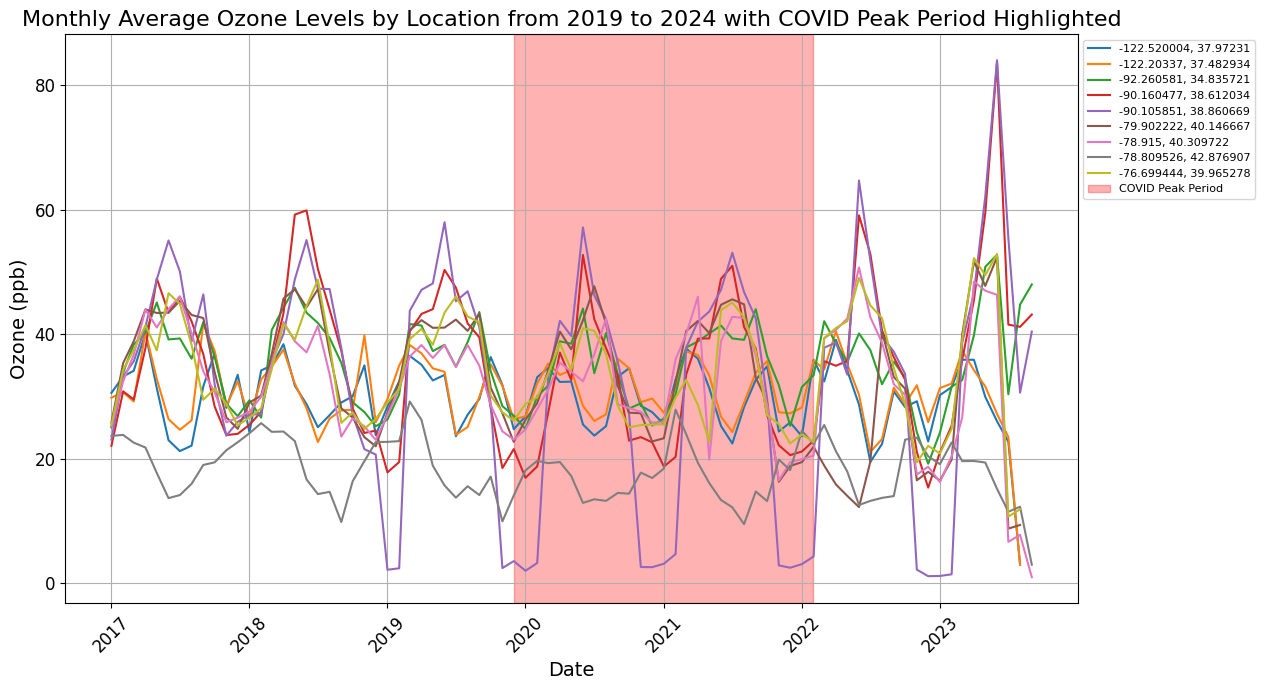

In [2]:

path_aqi = os.path.join(os.getcwd(), "data", "AQI_top_10.csv")
aqi_data = pd.read_csv(path_aqi)
aqi_data['Date Local'] = pd.to_datetime(aqi_data['Date Local'])
aqi_data_filtered = aqi_data[(aqi_data['Date Local'] >= '2017-01-01') & (aqi_data['Date Local'] <= '2023-12-31')]

covid_peak_start = '2019-12-01'
covid_peak_end = '2022-01-31'

aqi_data_filtered['YearMonth'] = aqi_data_filtered['Date Local'].dt.to_period('M')
grouped_ozone = aqi_data_filtered.groupby(['YearMonth', 'Longitude', 'Latitude'])['Ozone'].mean().reset_index()
grouped_ozone['YearMonth'] = grouped_ozone['YearMonth'].dt.to_timestamp()

pivoted_ozone = grouped_ozone.pivot(index='YearMonth', columns=['Longitude', 'Latitude'], values='Ozone')

plt.figure(figsize=(15, 7))

for column in pivoted_ozone.columns:
    plt.plot(pivoted_ozone.index, pivoted_ozone[column], label=f"{column[0]}, {column[1]}")

plt.axvspan(covid_peak_start, covid_peak_end, color='red', alpha=0.3, label='COVID Peak Period')

plt.title("Monthly Average Ozone Levels by Location from 2019 to 2024 with COVID Peak Period Highlighted", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Ozone (ppb)", fontsize=14)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()


C:\Users\Rybeardawg1\AppData\Local\Temp\ipykernel_492\1159920529.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us["Date"] = pd.to_datetime(df_us["Date"])
C:\Users\Rybeardawg1\AppData\Local\Temp\ipykernel_492\1159920529.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)


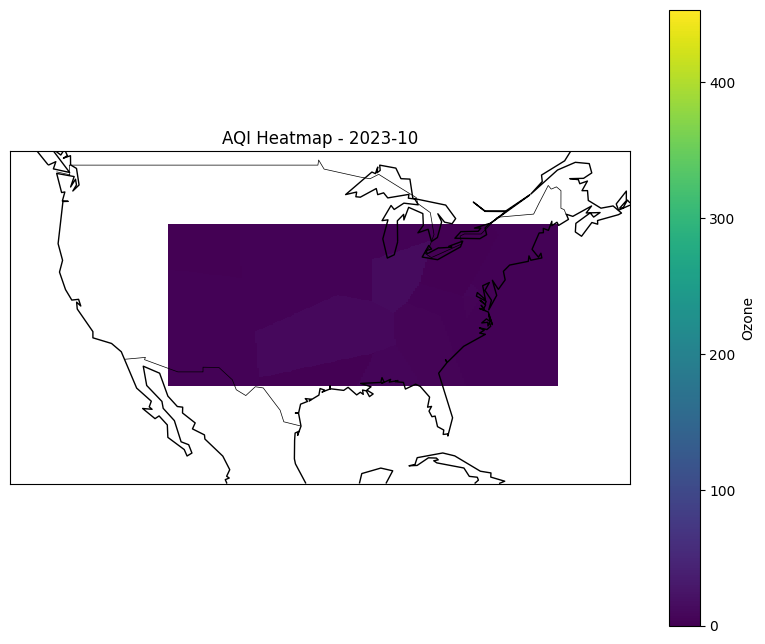

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import imageio
import os

csv_file = os.path.join("data", "climate_change_AQI.csv")
df = pd.read_csv(csv_file)

us_lat_min, us_lat_max = 20, 50  
us_lon_min, us_lon_max = -130, -60  

df_us = df[
    (df["Latitude"] >= us_lat_min)
    & (df["Latitude"] <= us_lat_max)
    & (df["Longitude"] >= us_lon_min)
    & (df["Longitude"] <= us_lon_max)
]

df_us["Date"] = pd.to_datetime(df_us["Date"])

min_ozone = df["Ozone"].min()
max_ozone = df["Ozone"].max()

fig, ax = plt.subplots(figsize=(10, 8))
image_files = []

for date, time_frame_data in df_us.groupby(df_us["Date"].dt.to_period("M")):
    fig.clf() 

    m = Basemap(
        projection="merc",
        llcrnrlat=us_lat_min,
        urcrnrlat=us_lat_max,
        llcrnrlon=us_lon_min,
        urcrnrlon=us_lon_max,
        resolution="c",
    )

    x, y = m(time_frame_data["Longitude"].values, time_frame_data["Latitude"].values)

    xi, yi = np.meshgrid(
        np.linspace(min(x), max(x), 200), np.linspace(min(y), max(y), 200)
    )

    zi = griddata((x, y), time_frame_data["Ozone"].values, (xi, yi), method="nearest")

    for i in range(len(xi)):
        for j in range(len(yi)):
            lon, lat = m(xi[i, j], yi[i, j], inverse=True)
            if not (
                us_lon_min <= lon <= us_lon_max and us_lat_min <= lat <= us_lat_max
            ):
                zi[j, i] = np.nan

    zi[np.isnan(zi)] = -1  
    zi[zi > max_ozone] = max_ozone
    zi[zi < min_ozone] = min_ozone

    m.pcolormesh(
        xi, yi, zi, cmap="viridis", shading="auto", vmin=min_ozone, vmax=max_ozone
    )

    m.drawcoastlines()
    m.drawcountries()
    plt.colorbar(label="Ozone")

    plt.title(
        "AQI Heatmap - {}".format(date.strftime("%Y-%m"))
    )  # Format date as YYYY-MM

    # Save the current figure as an image file
    image_file = "frame_{}.png".format(date.strftime("%Y-%m"))  # Format date as YYYY-MM
    plt.savefig(image_file)
    image_files.append(image_file)

with imageio.get_writer("AQI_monthly_timelapse.gif", mode="I", duration=0.5) as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

for image_file in image_files:
    os.remove(image_file)

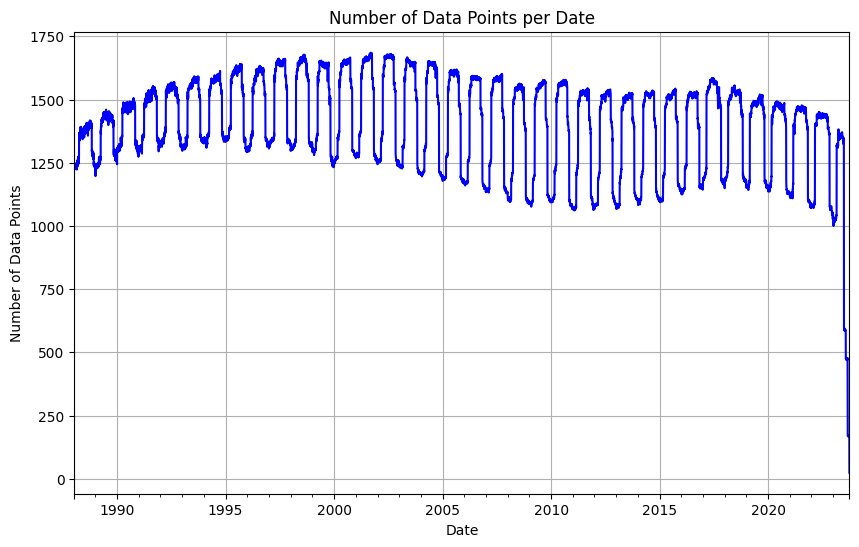

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_file = os.path.join("data", "climate_change_AQI.csv")
df = pd.read_csv(csv_file)

df['Date'] = pd.to_datetime(df['Date'])

data_per_date = df.groupby('Date').size()

plt.figure(figsize=(10, 6))
data_per_date.plot(kind='line', color='b', linestyle='-')
plt.title('Number of Data Points per Date')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.grid(True)
plt.show()